YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed



Optimal Weights (Black-Litterman):
OrderedDict({'AAPL': 0.30914, 'AMZN': 0.22218, 'GOOG': 0.18451, 'MSFT': 0.28417})


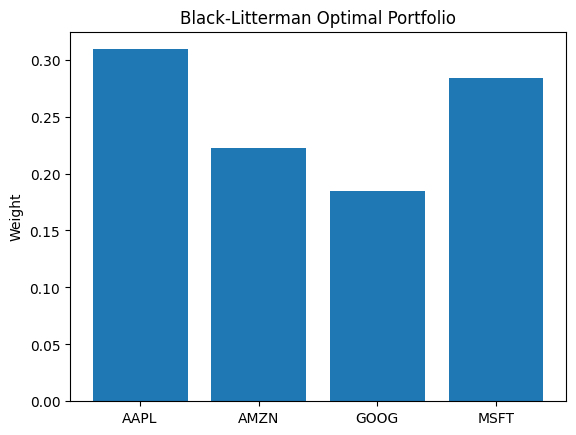

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from pypfopt.black_litterman import BlackLittermanModel, market_implied_risk_aversion
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt

# Load sample data
tickers = ["AAPL", "MSFT", "GOOG", "AMZN"]
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Close']

# Calculate historical returns and covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Step 1: Compute equilibrium market returns (CAPM-implied)
market_caps = np.array([2.5e12, 2.3e12, 1.5e12, 1.8e12])  # Example market caps
mcaps_series = pd.Series(market_caps, index=tickers)
delta = market_implied_risk_aversion(data.iloc[-1])  # ~2.5–3 by default
prior = delta * S @ mcaps_series / mcaps_series.sum()

# Step 2: Create non-ML views (simple momentum + valuation signals)
momentum = data.pct_change(90).iloc[-1]  # 3-month momentum
valuation = 1 / mu  # crude valuation proxy: inverse historical return

# Combine into views
views = 0.5 * momentum + 0.5 * valuation
views = views / np.linalg.norm(views) * 0.05  # scale to ~5% target return

# Create uncertainty (more signal → lower variance)
confidence = np.abs(views) / views.abs().max()
omega = np.diag((1 - confidence + 0.05))  # add small floor for stability

# Step 3: Apply Black-Litterman model
bl = BlackLittermanModel(S, pi=prior, absolute_views=views, omega=omega)
bl_return = bl.bl_returns()
bl_cov = bl.bl_cov()

# Step 4: Get portfolio weights
ef = EfficientFrontier(bl_return, bl_cov)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print("\nOptimal Weights (Black-Litterman):")
print(cleaned_weights)

# Plot portfolio allocation
plt.bar(cleaned_weights.keys(), cleaned_weights.values())
plt.title("Black-Litterman Optimal Portfolio")
plt.ylabel("Weight")
plt.show()
